In [169]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os

import string 

from sklearn.pipeline import Pipeline
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import cross_validate

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import layers, Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical

import optuna

In [86]:
def plot_history(history, title='', axs=None, exp_name=""):
    if axs is not None:
        ax1, ax2 = axs
    else:
        f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
    
    if len(exp_name) > 0 and exp_name[0] != '_':
        exp_name = '_' + exp_name
    ax1.plot(history.history['loss'], label = 'train' + exp_name)
    ax1.plot(history.history['val_loss'], label = 'val' + exp_name)
    ax1.set_ylim(0., 3)
    ax1.set_title('loss')
    ax1.legend()

    ax2.plot(history.history['accuracy'], label='train accuracy'  + exp_name)
    ax2.plot(history.history['val_accuracy'], label='val accuracy'  + exp_name)
    ax2.set_ylim(0., 1.0)
    ax2.set_title('Accuracy')
    ax2.legend()
    return (ax1, ax2)

In [87]:
X_train = pd.read_csv("../raw_data/train_x.csv", delimiter=" ", index_col="Id")["Title"]
y_train = pd.read_csv("../raw_data/train_y.csv", delimiter=" ", index_col="Id")['Genre_id']
X_test = pd.read_csv("../raw_data/test_x.csv", delimiter=" ", index_col="Id")["Title"]
y_test = pd.read_csv("../raw_data/test_y.csv", delimiter=" ", index_col="Id")['Genre_id']

In [88]:
X_train

Id
0               With Schwarzkopf: Life Lessons of The Bear
1        Magnets: Pulling Together, Pushing Apart (Amaz...
2        Energy Security (SAGE Library of International...
3             An Amish Gathering: Life in Lancaster County
4        City of Rocks Idaho: A Climber's Guide (Region...
                               ...                        
51295                                         Extreme Prey
51296    The Crime Writer's Guide to Police Practice an...
51297                          The Jezebel Remedy: A novel
51298                                              Startup
51299       Killer Takeout: A Key West Food Critic Mystery
Name: Title, Length: 51300, dtype: object

In [89]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X_train)
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)

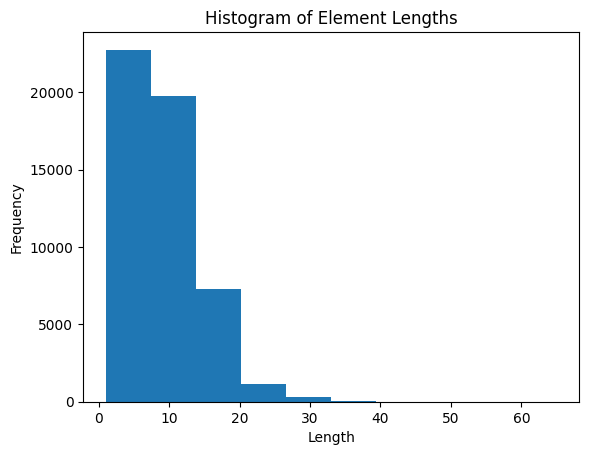

In [90]:
lengths = []
for element in X_train_token:
    lengths.append(len(element))

plt.hist(lengths, bins=10)  # Adjust the number of bins as needed
plt.xlabel('Length')
plt.ylabel('Frequency')
plt.title('Histogram of Element Lengths')
plt.show()

In [91]:
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='post', value=0, maxlen=40)
X_test_pad = pad_sequences(X_test_token, dtype='float32', padding='post', value=0, maxlen=40)
X_train_pad

array([[1.2000e+01, 1.8795e+04, 1.9000e+01, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.8796e+04, 1.8797e+04, 1.2390e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [6.0400e+02, 4.9700e+02, 3.5470e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       ...,
       [1.0000e+00, 1.6942e+04, 6.0720e+03, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [5.8430e+03, 0.0000e+00, 0.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00],
       [1.2650e+03, 1.4085e+04, 4.0000e+00, ..., 0.0000e+00, 0.0000e+00,
        0.0000e+00]], dtype=float32)

In [92]:
y_train_cat = to_categorical(y_train, num_classes=30)
y_test_cat = to_categorical(y_test, num_classes=30)
y_train_cat.shape

(51300, 30)

In [93]:
vocab_size = len(tokenizer.word_counts)
vocab_size

36975

In [160]:
def initialize_model():
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1, # 16 +1 for the 0 padding
        output_dim=20,
        input_length=40,
        mask_zero=True, # Built-in masking layer :)
    ))

    model.add(layers.Conv1D(30, kernel_size=3))
    
    model.add(layers.Flatten())
    
    model.add(layers.Dense(30, activation="softmax"))
    
    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])
    
    return model

In [161]:
model_cnn = initialize_model()

es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")

history = model_cnn.fit(X_train_pad, y_train_cat, 
              epochs=1000, 
              batch_size=16,
              validation_split=0.3,
              callbacks=[es]
             )


res = model_cnn.evaluate(X_test_pad, y_test_cat, verbose=0)

print(f'The accuracy evaluated on the test set is of {res[1]*100:.3f}%')

Epoch 1/1000
2245/2245 [==============================] - 9s 4ms/step - loss: 2.8802 - accuracy: 0.1857 - val_loss: 3.1292 - val_accuracy: 0.1503
Epoch 2/1000
2245/2245 [==============================] - 8s 4ms/step - loss: 2.2312 - accuracy: 0.3810 - val_loss: 2.6527 - val_accuracy: 0.2502
Epoch 3/1000
2245/2245 [==============================] - 8s 4ms/step - loss: 1.9197 - accuracy: 0.4788 - val_loss: 2.5904 - val_accuracy: 0.2890
Epoch 4/1000
2245/2245 [==============================] - 8s 4ms/step - loss: 1.7156 - accuracy: 0.5425 - val_loss: 2.5924 - val_accuracy: 0.3147
Epoch 5/1000
2245/2245 [==============================] - 9s 4ms/step - loss: 1.5612 - accuracy: 0.5892 - val_loss: 2.6123 - val_accuracy: 0.3172
Epoch 6/1000
2245/2245 [==============================] - 8s 4ms/step - loss: 1.4352 - accuracy: 0.6233 - val_loss: 2.4804 - val_accuracy: 0.3550
Epoch 7/1000
2245/2245 [==============================] - 8s 4ms/step - loss: 1.3249 - accuracy: 0.6545 - val_loss: 2.6784 -

(<AxesSubplot:title={'center':'loss'}>,
 <AxesSubplot:title={'center':'Accuracy'}>)

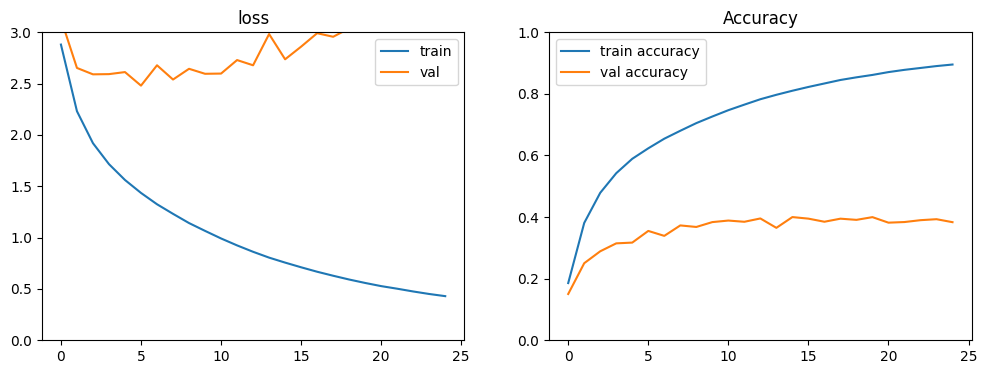

In [163]:
plot_history(history)

In [165]:
y_pred = np.argmax(model_cnn.predict(X_test_pad), axis=1)


179/179 [==============================] - 0s 2ms/step


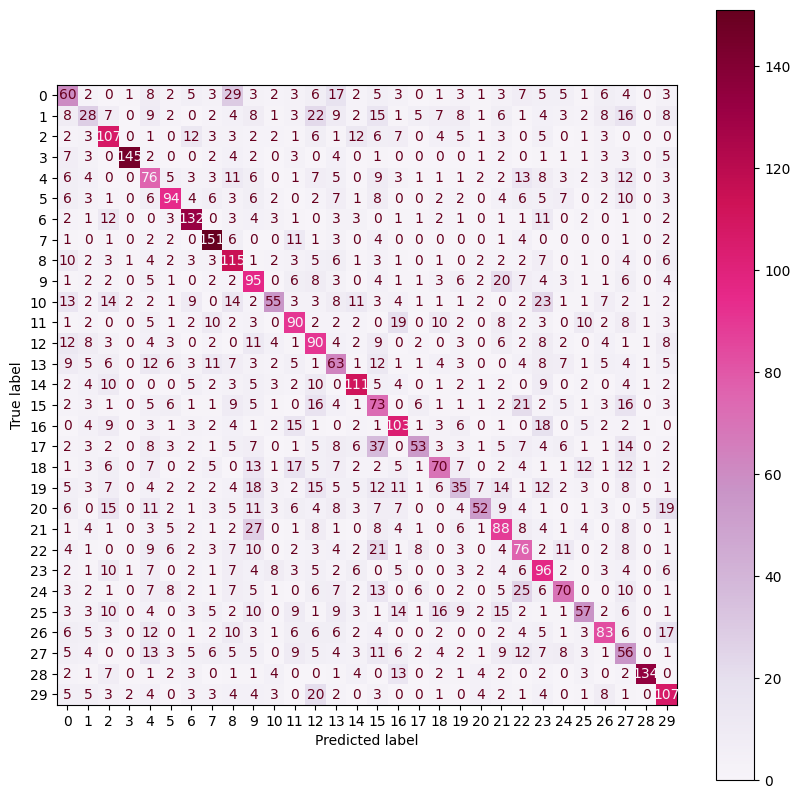

In [166]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)

fig, ax = plt.subplots(figsize=(10, 10))
disp.plot(cmap="PuRd", ax=ax)

# Search space using optuna

In [174]:
def create_model(trial):
    model = Sequential()
    model.add(layers.Embedding(
        input_dim=vocab_size+1,
        output_dim=trial.suggest_int("embedding_units", 10, 50),
        input_length=40,
        mask_zero=True,
    ))

    model.add(layers.Conv1D(trial.suggest_int("conv_units", 10, 50), kernel_size=trial.suggest_int("kernel_size", 3, 5)))

    model.add(layers.Flatten())

    model.add(layers.Dense(30, activation="softmax"))

    model.compile(loss="categorical_crossentropy", optimizer="rmsprop", metrics=["accuracy"])

    return model

def objective(trial):
    model = create_model(trial)
    es = EarlyStopping(patience=10, restore_best_weights=True, monitor="val_accuracy")
    history = model.fit(X_train_pad, y_train_cat, 
                        epochs=1000,
                        batch_size=32,
                        validation_split=0.3,
                        callbacks=[es],
                        verbose=0)
    return history.history["val_accuracy"][-1]

In [175]:
study = optuna.create_study(direction="maximize")
study.optimize(objective, n_trials=100, n_jobs=-1)

[I 2023-06-14 14:25:37,405] A new study created in memory with name: no-name-0596abe9-e3bb-4a3b-8c1e-101b71fc4a5e
[I 2023-06-14 14:47:07,393] Trial 11 finished with value: 0.35867446660995483 and parameters: {'embedding_units': 44, 'conv_units': 29, 'kernel_size': 4}. Best is trial 11 with value: 0.35867446660995483.
[I 2023-06-14 14:47:40,306] Trial 0 finished with value: 0.3908382058143616 and parameters: {'embedding_units': 30, 'conv_units': 41, 'kernel_size': 5}. Best is trial 0 with value: 0.3908382058143616.
[I 2023-06-14 14:49:19,528] Trial 9 finished with value: 0.36829110980033875 and parameters: {'embedding_units': 21, 'conv_units': 45, 'kernel_size': 5}. Best is trial 0 with value: 0.3908382058143616.
[I 2023-06-14 14:50:38,237] Trial 10 finished with value: 0.36731642484664917 and parameters: {'embedding_units': 29, 'conv_units': 16, 'kernel_size': 4}. Best is trial 0 with value: 0.3908382058143616.
[I 2023-06-14 14:51:21,912] Trial 5 finished with value: 0.3770630359649658

KeyboardInterrupt: 